In [1]:
pip install visualkeras


In [2]:
import os
import numpy as np 
import pandas as pd 
import imageio
import tifffile as tiff
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.layers import Input, Conv2DTranspose,concatenate, Conv2D,Dropout,MaxPooling2D
import tensorflow as tf
import matplotlib.pyplot as plt
import visualkeras
from sklearn.model_selection import KFold, train_test_split
import imageio

from keras.callbacks import ModelCheckpoint ,ReduceLROnPlateau,EarlyStopping


In [3]:
path = ''
image_path = os.path.join(path, '/kaggle/input/water-segmentation/Water_seg/images/')
label_path = os.path.join(path, '/kaggle/input/water-segmentation/Water_seg/New labels/')
image_list_orig = os.listdir(image_path)
label_list_orig = os.listdir(label_path)

image_list = [image_path+i for i in image_list_orig]
label_list = [label_path+i for i in label_list_orig]

In [4]:
# Ensure both lists are sorted identically before splitting
image_list.sort()
label_list.sort()

In [5]:
print(image_list[:3])
print(label_list[:3])


['/kaggle/input/water-segmentation/Water_seg/images/0.tif', '/kaggle/input/water-segmentation/Water_seg/images/1.tif', '/kaggle/input/water-segmentation/Water_seg/images/10.tif']
['/kaggle/input/water-segmentation/Water_seg/New labels/0.png', '/kaggle/input/water-segmentation/Water_seg/New labels/1.png', '/kaggle/input/water-segmentation/Water_seg/New labels/10.png']


/tmp/ipykernel_5923/795488910.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
/tmp/ipykernel_5923/795488910.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(label_list[N])


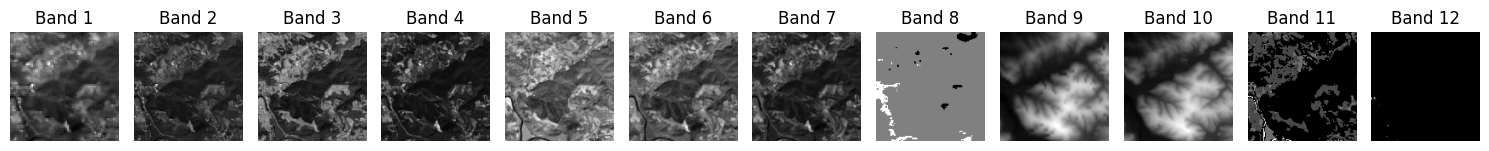

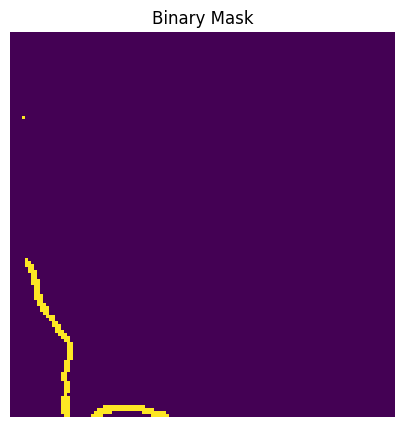

In [6]:
N = 1
img = imageio.imread(image_list[N])
mask = imageio.imread(label_list[N])
num_bands = img.shape[-1]
fig, axes = plt.subplots(1, num_bands, figsize=(15, 5))
for i in range(num_bands):
    axes[i].imshow(img[:, :,i],cmap='gray')
    axes[i].set_title(f'Band {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


plt.figure(figsize=(5, 5))
plt.imshow(mask)  
plt.title('Binary Mask')
plt.axis('off')
plt.show()

In [7]:


# Split into training and remaining sets
train_images, remaining_images, train_labels, remaining_labels = train_test_split(
    image_list, label_list, test_size=0.2, random_state=42  # 20% of the data will be split for validation and testing
)

# Further split remaining data into validation and testing sets
val_images, test_images, val_labels, test_labels = train_test_split(
    remaining_images, remaining_labels, test_size=0.50, random_state=42  # Split remaining data equally into validation and testing
)


print(f"Training set size: {len(train_images)} images, {len(train_labels)} labels")
print(f"Validation set size: {len(val_images)} images, {len(val_labels)} labels")
print(f"Testing set size: {len(test_images)} images, {len(test_labels)} labels")

Training set size: 244 images, 244 labels
Validation set size: 31 images, 31 labels
Testing set size: 31 images, 31 labels


In [9]:


# Data augmentation for training set
train_data_gen_args = dict(rescale=1./255,
#                            rotation_range=10,
#                            width_shift_range=0.1,
#                            height_shift_range=0.1,
#                            shear_range=0.1,
#                            zoom_range=0.1,
#                            .channel_shift_range = 0.2,
                           horizontal_flip=True,
#                            vertical_flip = True,
#                            fill_mode='nearest'
                          )

# Simple rescaling for validation and test sets
val_test_data_gen_args = dict(rescale=1./255)

# ImageDataGenerators
train_image_datagen = ImageDataGenerator(**train_data_gen_args)
train_mask_datagen = ImageDataGenerator(**train_data_gen_args)

val_image_datagen = ImageDataGenerator(**val_test_data_gen_args)
val_mask_datagen = ImageDataGenerator(**val_test_data_gen_args)

test_image_datagen = ImageDataGenerator(**val_test_data_gen_args)
test_mask_datagen = ImageDataGenerator(**val_test_data_gen_args)


def load_image(img_path, label_path, target_size):
    """
    Function to load and preprocess images and their corresponding masks.
    
    Parameters:
    - img_path: str, path to the image file
    - label_path: str, path to the label file
    - target_size: tuple, the desired size of the output images and masks
    
    Returns:
    - img: preprocessed image
    - mask: preprocessed mask
    """
    # Load the image
    img = imageio.imread(img_path)
    mask = imageio.imread(label_path)
    
    # If the mask is 2D, add a channel dimension
    if len(mask.shape) == 2:
        mask = np.expand_dims(mask, axis=-1)
    
    # Resize the image and mask to target_size
    img = tf.image.resize(img, target_size)
    mask = tf.image.resize(mask, target_size)
    
    
    
    # Ensure mask is binary (0 or 1)
    mask = tf.cast(mask > 0.5, tf.float32)
    
    return img, mask

def apply_random_transform(image, mask, seed=None):
    """
    Apply the same random transformation to both image and mask.
    
    Parameters:
    - image: TensorFlow tensor or Numpy array, the image to transform
    - mask: TensorFlow tensor or Numpy array, the mask to transform
    - seed: int, seed for random number generator
    
    Returns:
    - Transformed image and mask
    """
    if seed is not None:
        tf.random.set_seed(seed)
    
    # Use ImageDataGenerator for transformation
    image = image.numpy()  # Convert the image tensor to a numpy array
    mask = mask.numpy()  # Convert the mask tensor to a numpy array
    
    image = train_image_datagen.random_transform(image, seed=seed)
    mask = train_mask_datagen.random_transform(mask, seed=seed)
    
    return image, mask

def train_generator(image_list, label_list, batch_size, target_size, image_datagen, mask_datagen):
    """
    A generator to yield batches of images and masks.
    
    Parameters:
    - image_list: list, list of image file paths
    - label_list: list, list of label file paths
    - batch_size: int, number of images per batch
    - target_size: tuple, desired output size of the images and masks
    - image_datagen: ImageDataGenerator instance for augmenting the images
    - mask_datagen: ImageDataGenerator instance for augmenting the masks
    
    Yields:
    - Tuple of (images, masks)
    """
    while True:
        X_batch = []
        y_batch = []

        for i in range(batch_size):
            # Choose a random index
            idx = np.random.randint(0, len(image_list)-1)
            
            # Get the paths for the image and label
            img_path = image_list[idx]
            label_path = label_list[idx]
            
            # Load and preprocess the image and mask
            img, mask = load_image(img_path, label_path, target_size)
            
            # Apply random transformations
            seed = np.random.randint(1e6)
            img, mask = apply_random_transform(img, mask, seed=seed)
            
            X_batch.append(img)
            y_batch.append(mask)
        
        # Convert lists to numpy arrays
        X_batch = np.array(X_batch)
        y_batch = np.array(y_batch)
        
        yield X_batch, y_batch
        

In [11]:
# Parameters
img_height = 128
img_width = 128
num_channels = 12
batch_size = 8
image_size = (128, 128)  # Desired size for images
# Train, validation, and test generators
train_gen = train_generator(train_images, train_labels, batch_size, image_size, train_image_datagen, train_mask_datagen)
val_gen = train_generator(val_images, val_labels, batch_size, image_size, val_image_datagen, val_mask_datagen)
test_gen = train_generator(test_images, test_labels, batch_size, image_size, test_image_datagen, test_mask_datagen)

/tmp/ipykernel_5923/4140873302.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)
/tmp/ipykernel_5923/4140873302.py:53: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(label_path)


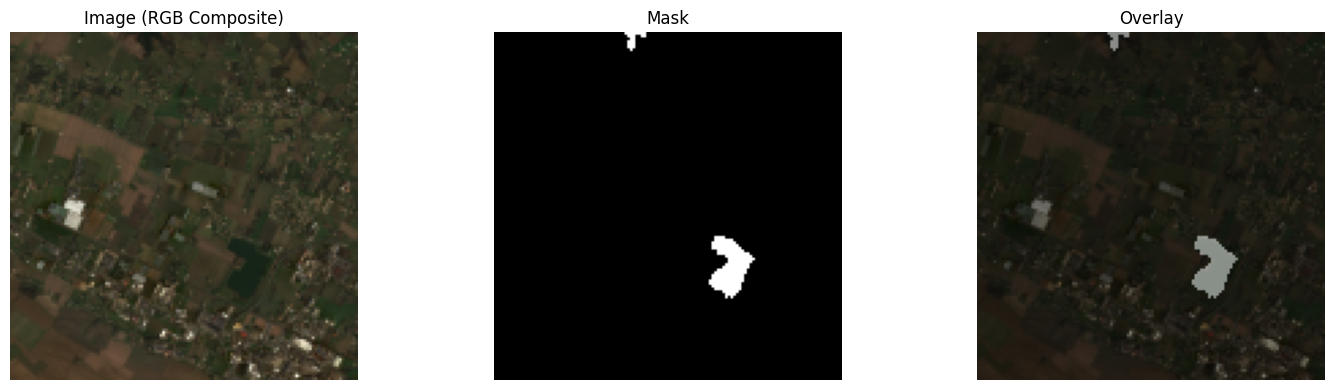

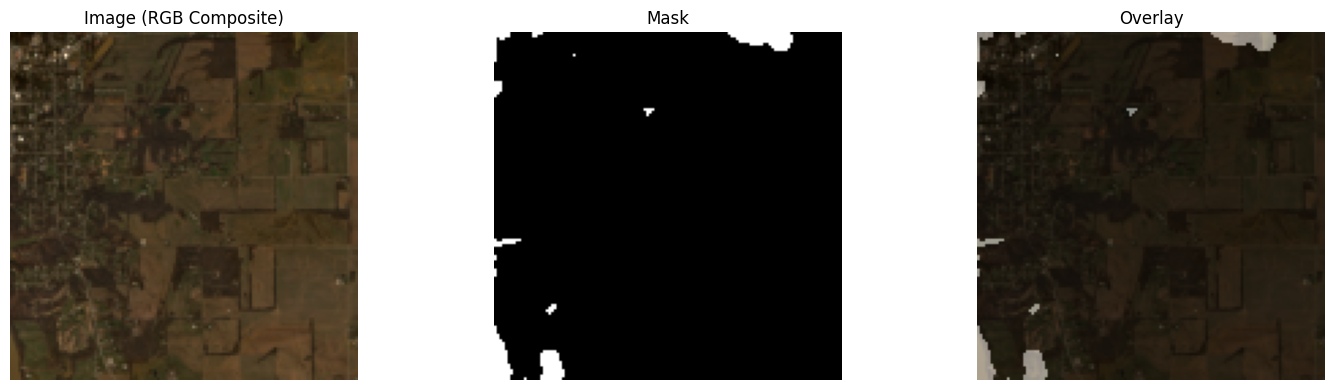

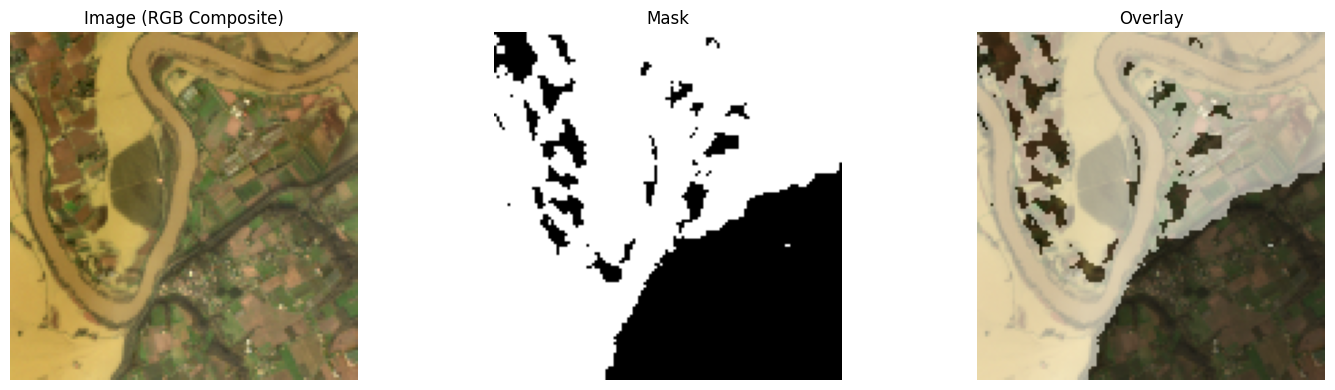

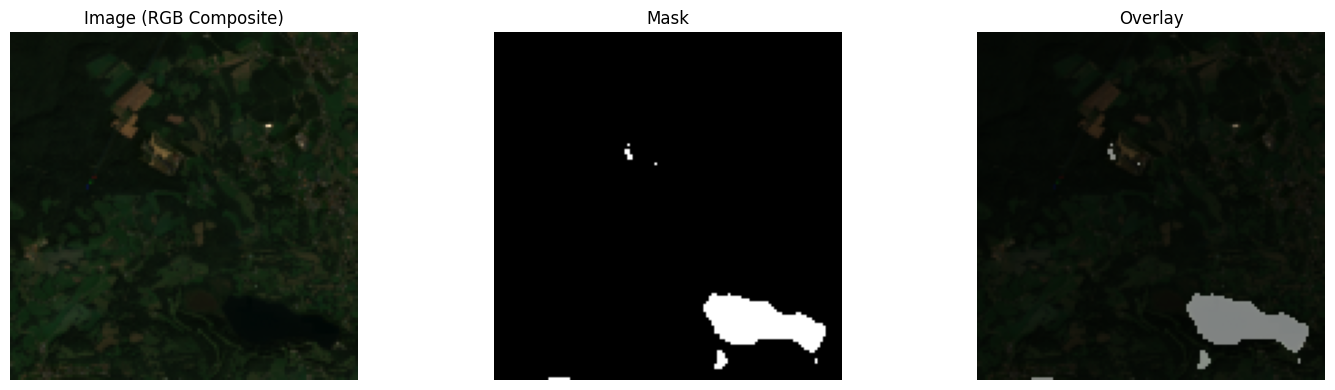

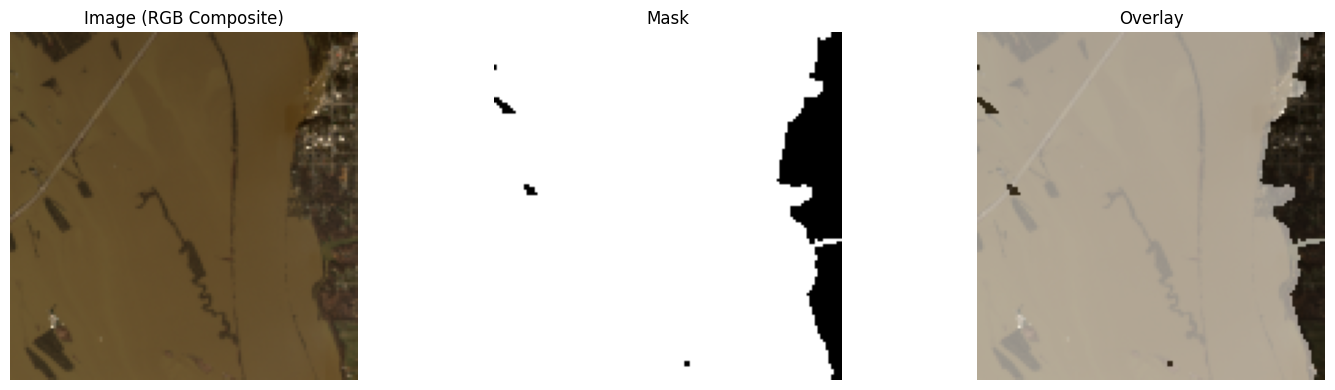

In [15]:
def visualize_generator_output(generator, num_samples=5, figsize=(15, 4)):
    """
    Visualize samples from the data generator.
    
    Parameters:
    - generator: generator yielding batches of (images, masks)
    - num_samples: int, number of samples to visualize
    - figsize: tuple, size of the figure for each sample
    """
    # Get a batch from the generator
    images, masks = next(generator)
    
    # Visualize up to num_samples or the batch size, whichever is smaller
    n = min(num_samples, len(images))
    
    for i in range(n):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
        
        # Display the image
        # Assuming the image has 12 channels, we'll display an RGB composite using channels 3, 2, 1
        rgb_image = images[i][:,:,[3,2,1]]  # Adjust these indices if needed
        rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
        ax1.imshow(rgb_image)
        ax1.set_title("Image (RGB Composite)")
        ax1.axis('off')
        
        # Display the mask
        ax2.imshow(masks[i].squeeze(), cmap='gray')
        ax2.set_title("Mask")
        ax2.axis('off')
        
        # Display the overlay
        ax3.imshow(rgb_image)
        ax3.imshow(masks[i].squeeze(), alpha=0.5, cmap='gray')
        ax3.set_title("Overlay")
        ax3.axis('off')
        
        plt.tight_layout()
        plt.show()
visualize_generator_output(train_gen, num_samples=5)


In [16]:

def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         
        conv = Dropout(dropout_prob)(conv)
         
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [17]:

def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    
    return conv

In [18]:

def unet_model(input_size=(128, 128, 12), n_filters=32, n_classes=1):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) # Include a dropout of 0.3 for this layer
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)
    

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding and a sigmoid for the binary segmentation
    
    conv10 = Conv2D(n_classes, 1,activation = 'sigmoid', padding='same')(conv9)
    
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [20]:

unet = unet_model((img_height, img_width, num_channels))

In [21]:
unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      3,488 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8, 512) │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  1,179,904 │ dropout_1[0][0] 

 Total params: 8,642,337 (32.97 MB)

 Trainable params: 8,642,337 (32.97 MB)

 Non-trainable params: 0 (0.00 B)

/opt/conda/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


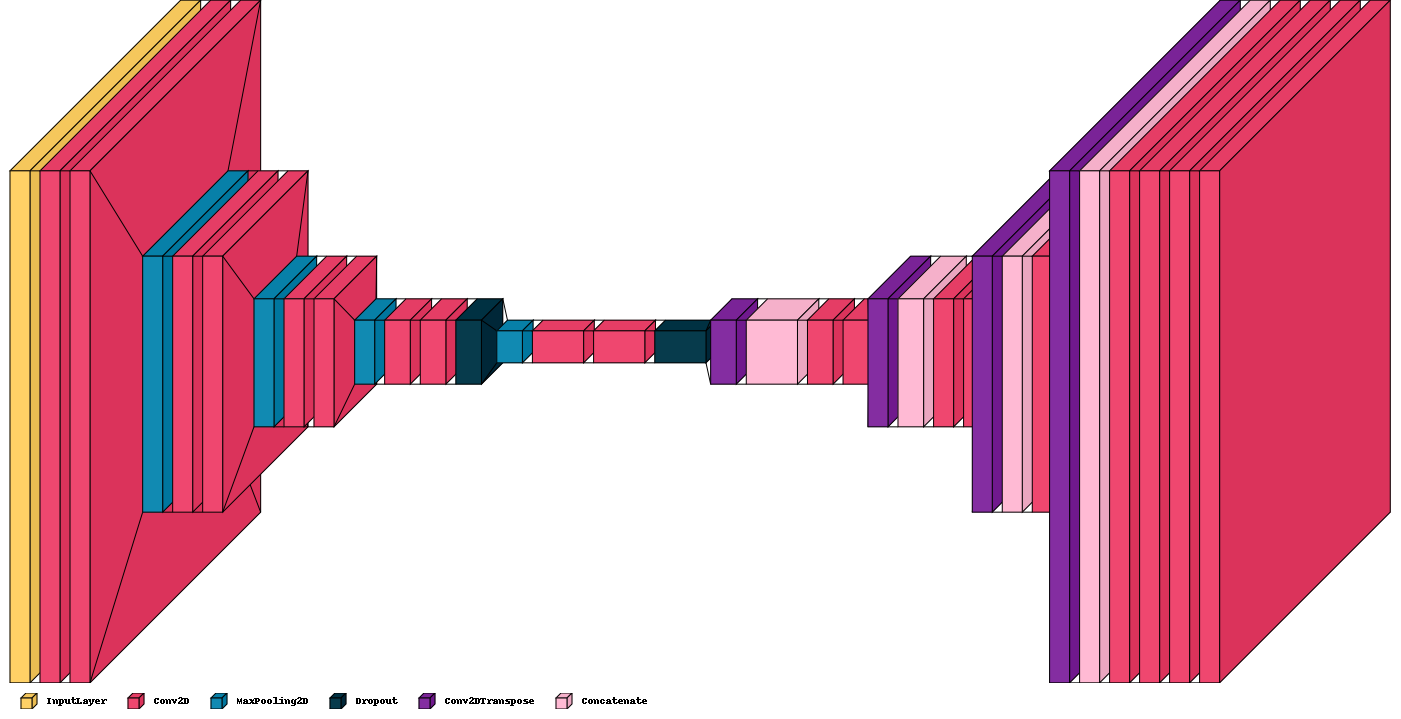

In [22]:
visualkeras.layered_view(unet,legend=True,to_file="unet_model.png")

In [26]:


def dice_loss(y_true, y_pred):
    smooth = 1.0  # Smoothing factor to avoid division by zero
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice_coeff = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return 1 - dice_coeff




In [28]:
target_class_ids = [0, 1]

metrics = ['accuracy',tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.BinaryIoU(target_class_ids=target_class_ids, name='iou') 
]

unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                           loss=dice_loss,
                           metrics=metrics)

In [29]:
# Create a callback that saves the model's weights
checkpoint = ModelCheckpoint(
    filepath='unet_model_checkpoint.keras',  # File path where the model will be saved
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,  # Verbosity mode, 1 will print messages when saving the model
    save_best_only=True,  # Save only the best model according to the monitored metric
    mode='max'  # Mode for the monitored metric, 'max' to save when it increases
)

In [30]:
#implement Early stopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

In [31]:
# trying different learning rates 

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=0.0000000001
)

In [32]:
his=unet.fit(train_gen, 
             epochs=50, 
             steps_per_epoch=len(train_images) // batch_size, 
             validation_data=val_gen,
             validation_steps=len(val_images) // batch_size,
             callbacks = [checkpoint, early_stopping, reduce_lr])



/tmp/ipykernel_5923/4140873302.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)
/tmp/ipykernel_5923/4140873302.py:53: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(label_path)


Epoch 1/50


I0000 00:00:1725378538.913996    5971 service.cc:145] XLA service 0x7e3cb0005bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725378538.914066    5971 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725378538.914073    5971 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/30 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.4870 - iou: 0.3004 - loss: 0.6391 - precision: 0.5255 - recall: 0.2564  

I0000 00:00:1725378554.630105    5971 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7576 - iou: 0.5726 - loss: 0.3927 - precision: 0.6055 - recall: 0.6038
Epoch 1: val_accuracy improved from -inf to 0.94449, saving model to unet_model_checkpoint.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 463ms/step - accuracy: 0.7604 - iou: 0.5757 - loss: 0.3899 - precision: 0.6088 - recall: 0.6060 - val_accuracy: 0.9445 - val_iou: 0.8196 - val_loss: 0.1861 - val_precision: 0.9208 - val_recall: 0.7484 - learning_rate: 0.0010
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9067 - iou: 0.7920 - loss: 0.1985 - precision: 0.8761 - recall: 0.7813
Epoch 2: val_accuracy did not improve from 0.94449
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 355ms/step - accuracy: 0.9061 - iou: 0.7908 - loss: 0.1992 - precision: 0.8746 - recall: 0.7807 - val_accuracy: 0.9154 - val_iou: 0.7618 - val_loss: 0.2333 - val_precision: 0.9111 - val_recall: 0.6619 - learning_rate: 0.0010
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.8944 - iou:

In [33]:
# To evaluate on the test set
results = unet.evaluate(test_gen, steps=len(test_images) // batch_size)


/tmp/ipykernel_5923/4140873302.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)
/tmp/ipykernel_5923/4140873302.py:53: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(label_path)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9419 - iou: 0.8552 - loss: 0.1318 - precision: 0.8825 - recall: 0.8753


/tmp/ipykernel_5923/4140873302.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)
/tmp/ipykernel_5923/4140873302.py:53: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(label_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


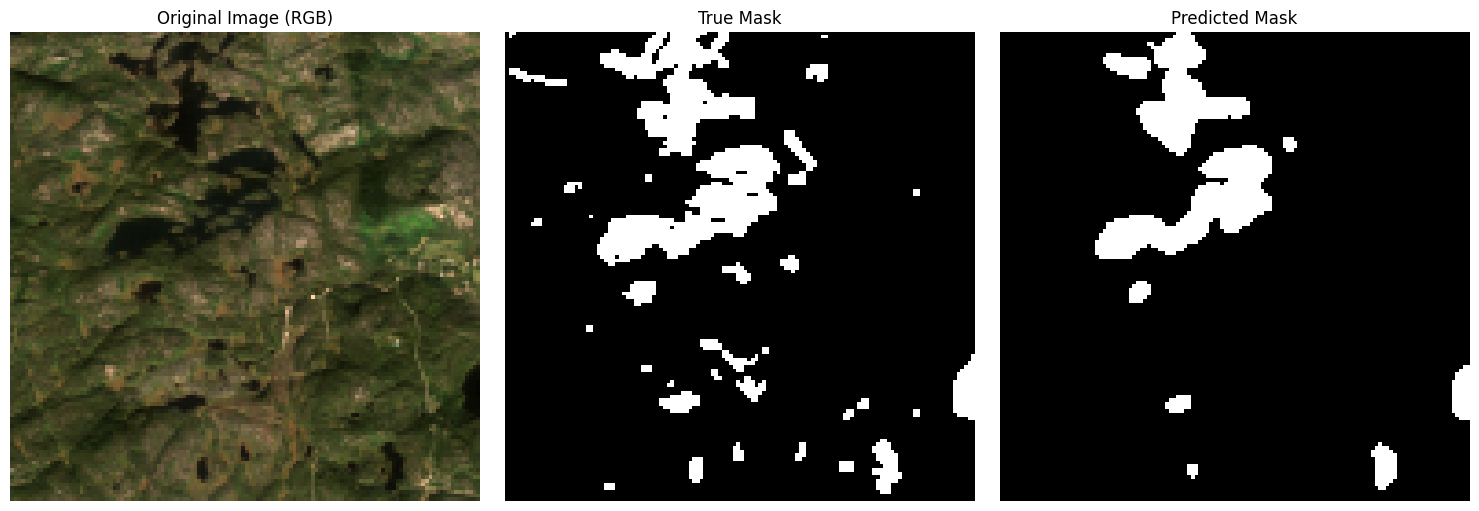

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


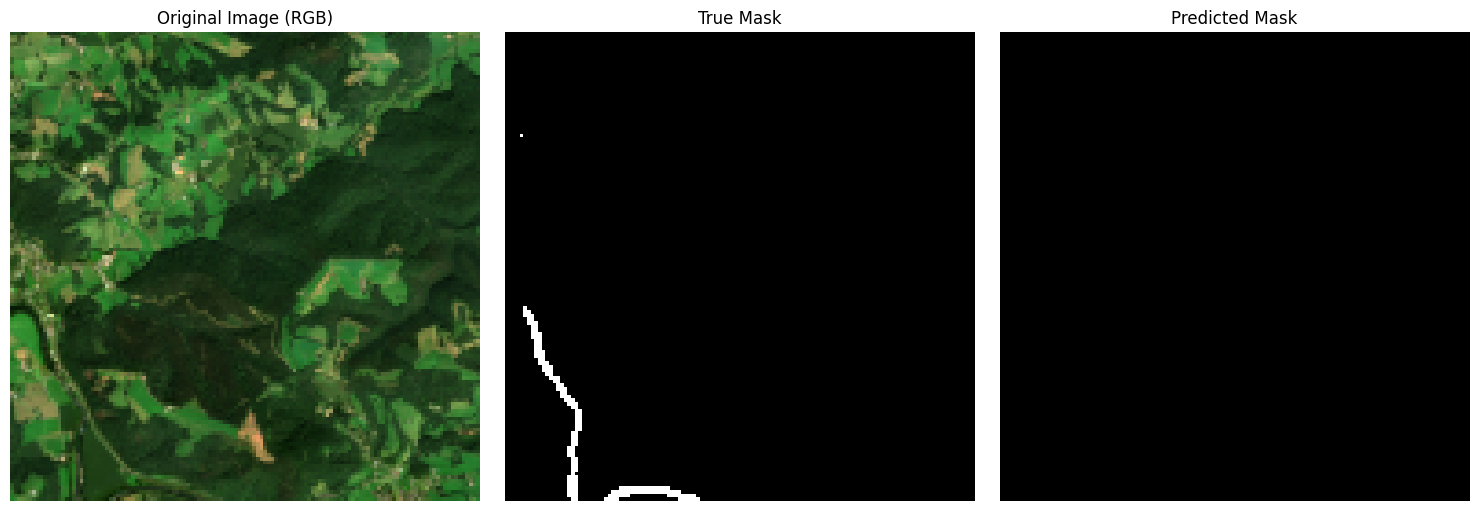

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


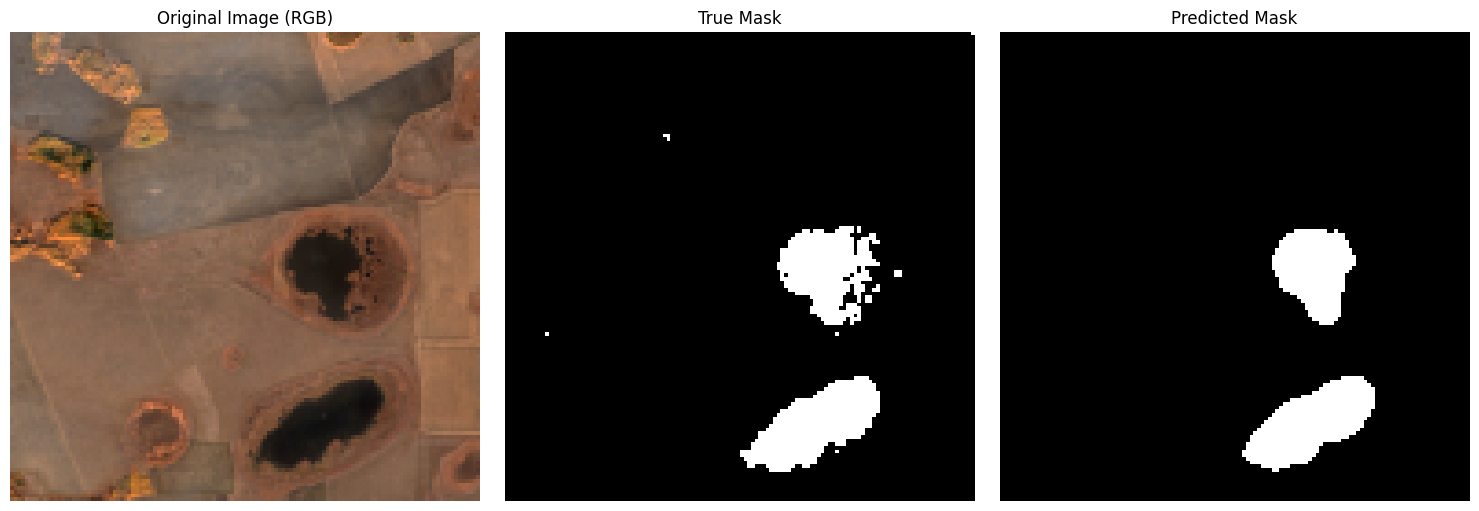

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


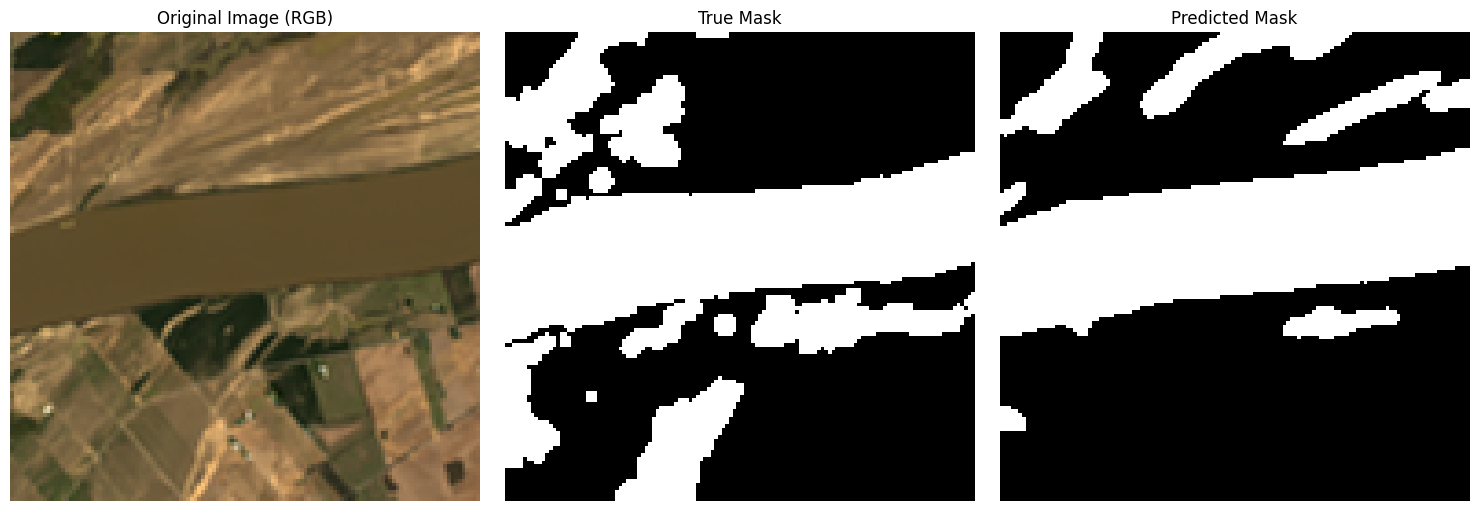

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


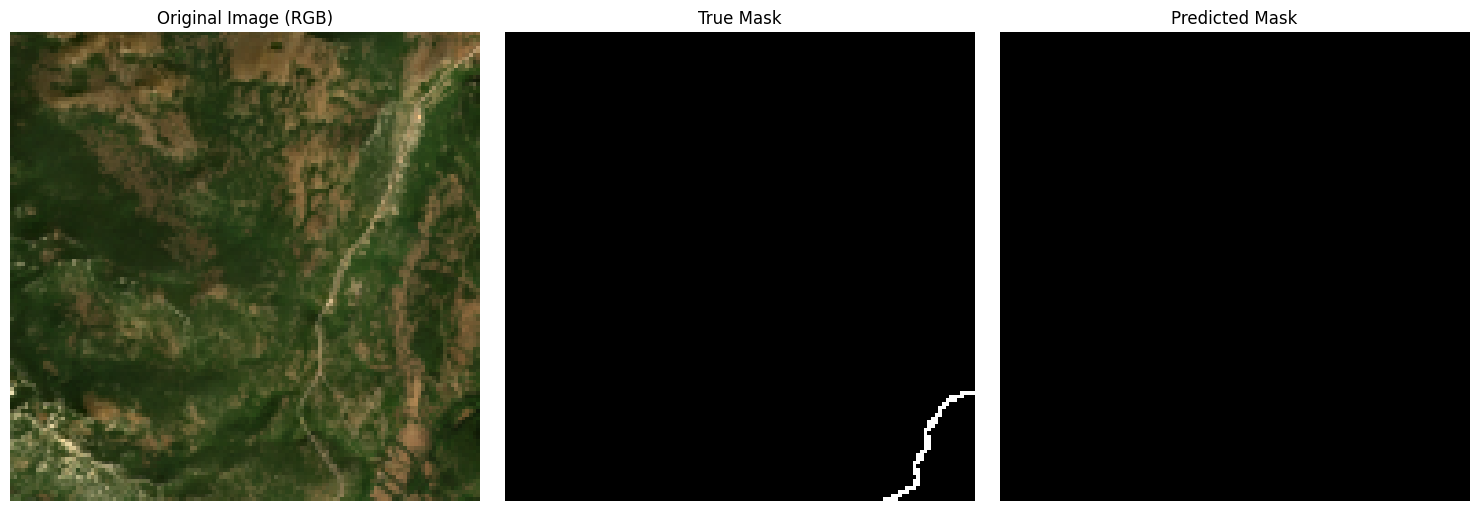

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


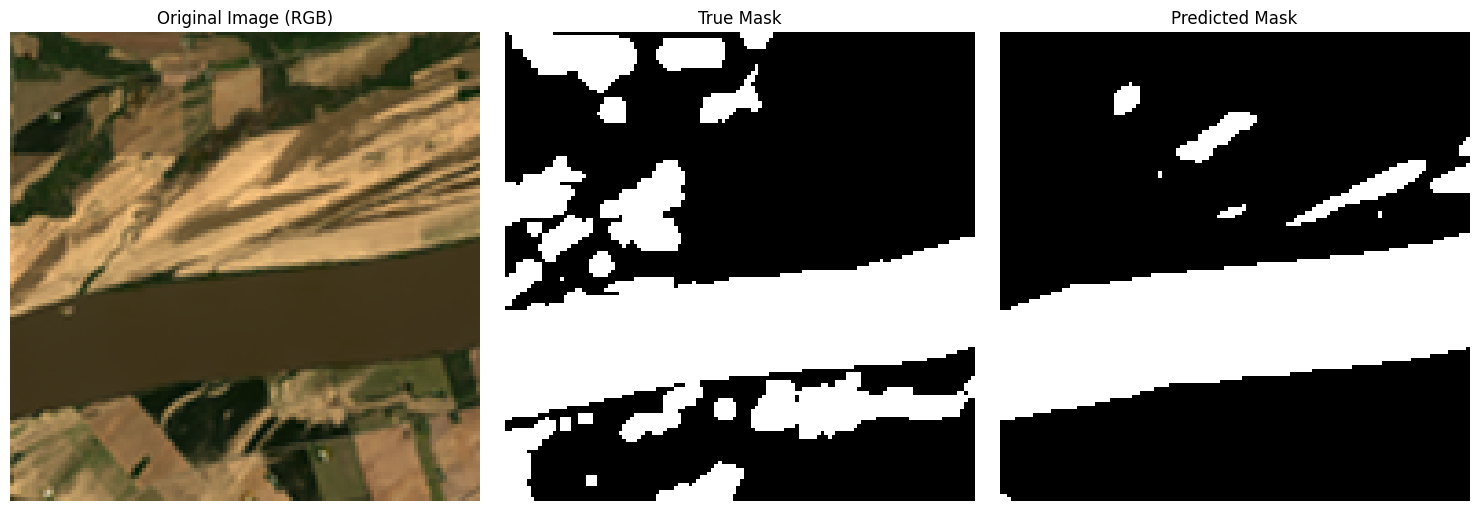

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


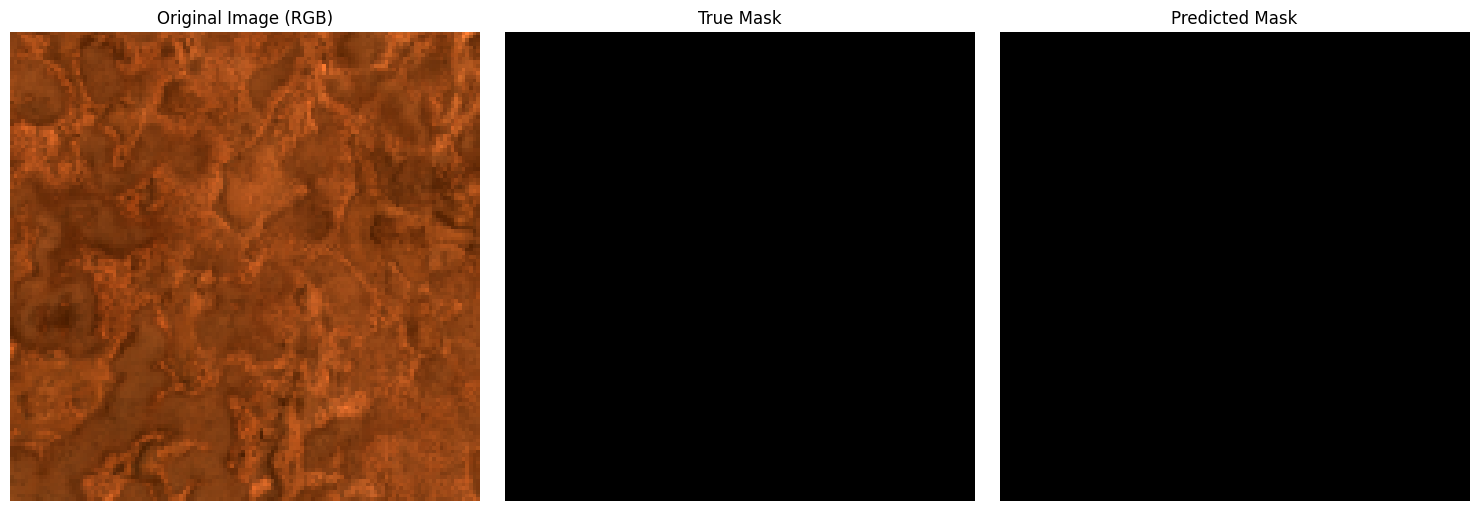

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


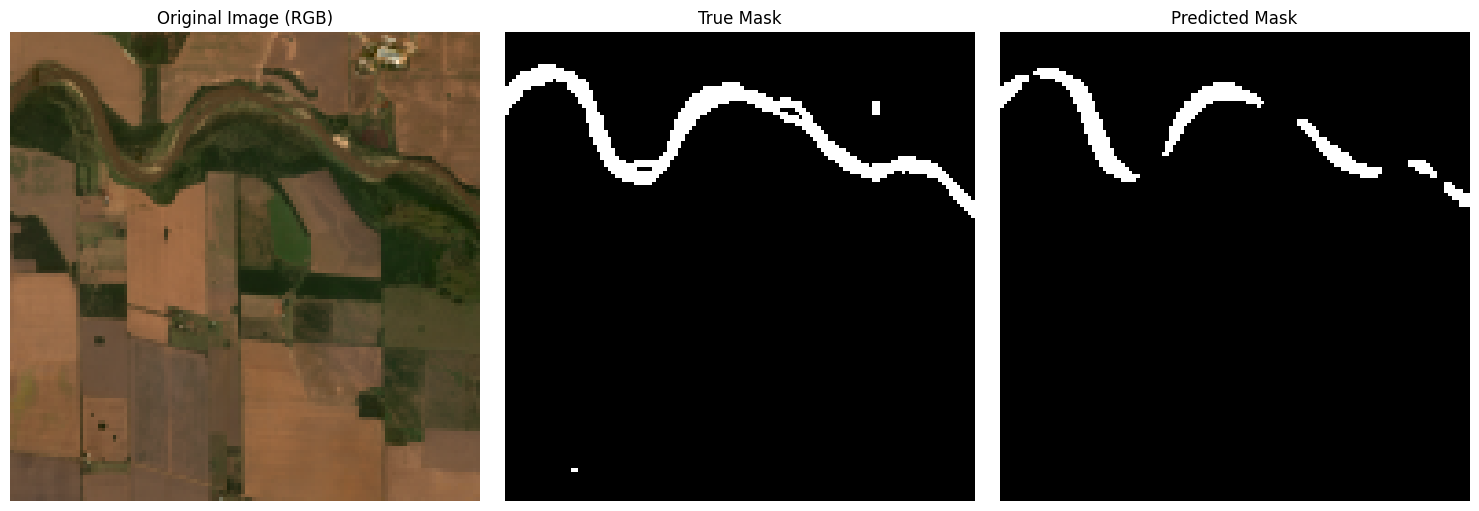

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


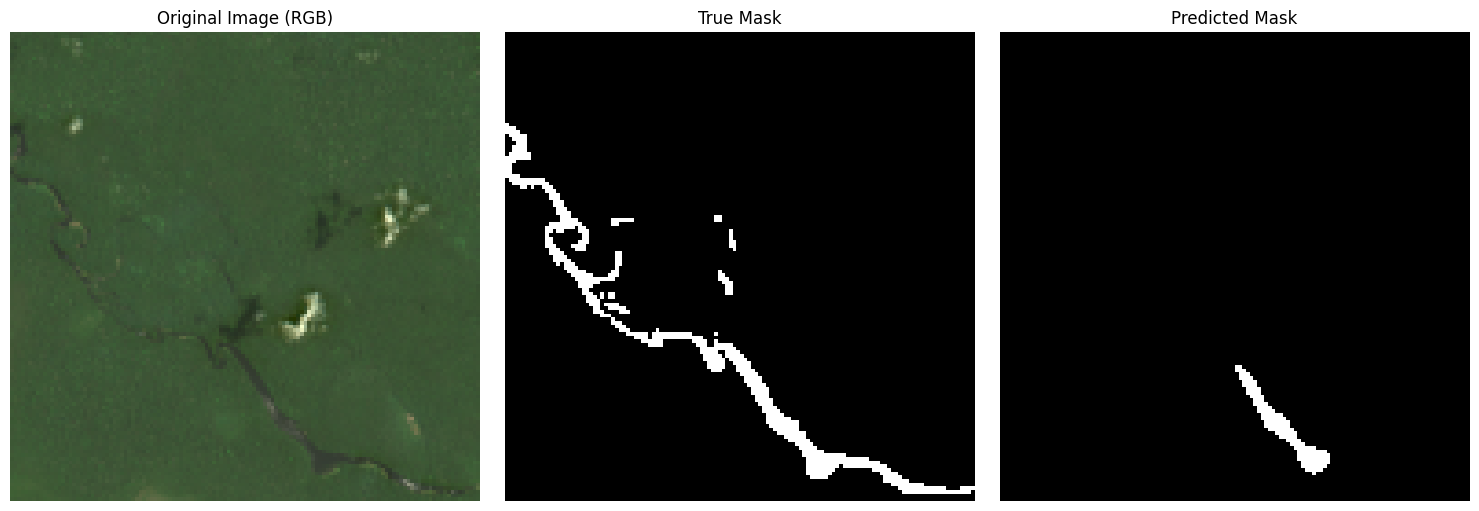

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


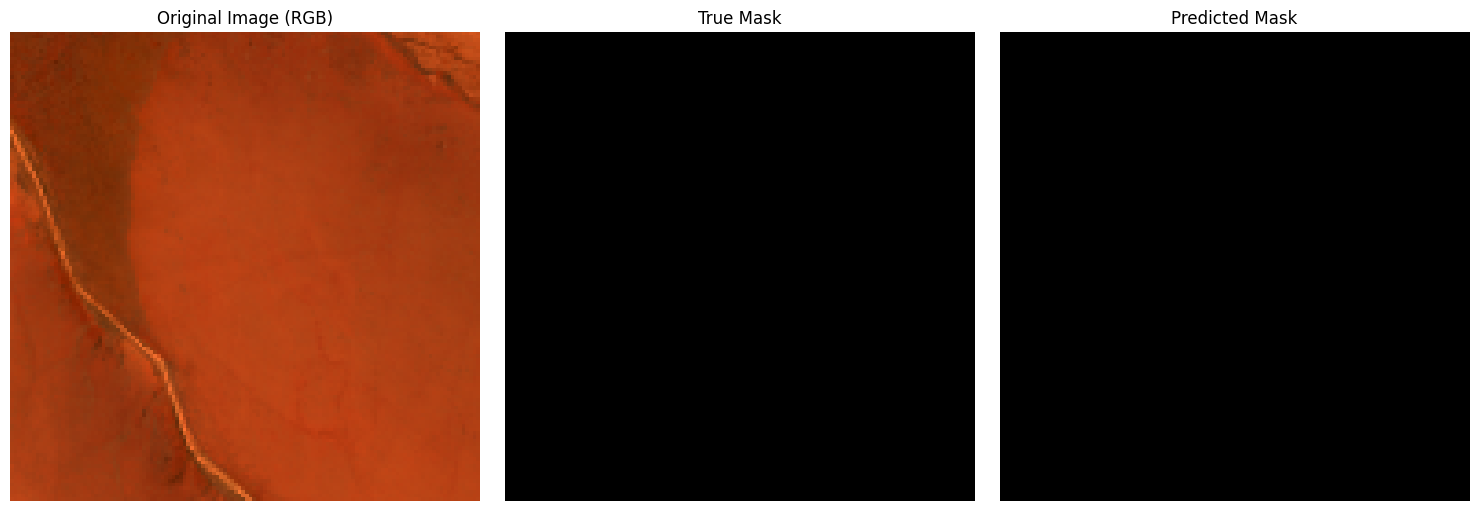

In [34]:
def plot_predictions(model, image_list, label_list, target_size, num_samples=10):
    """
    Function to plot original RGB images, true masks, and predicted masks.
    
    Parameters:
    - model: Trained segmentation model
    - image_list: List of paths to original images
    - label_list: List of paths to true mask images
    - target_size: Tuple of target size for the images and masks
    - num_samples: Number of samples to plot
    """
    for i in range(num_samples):
        img_path = image_list[i]
        label_path = label_list[i]
        
        # Load and preprocess the image and mask
        img, true_mask = load_image(img_path, label_path, target_size)
        
        # Predict the mask
        pred_mask = model.predict(tf.expand_dims(img, axis=0))[0]
        
        # Create RGB image for visualization (assuming channels 3, 2, 1 correspond to RGB)
        rgb_img = tf.stack([img[:,:,3], img[:,:,2], img[:,:,1]], axis=-1)
        
        # Convert to numpy and normalize for visualization
        rgb_img_np = rgb_img.numpy()
        rgb_img_np = (rgb_img_np - np.min(rgb_img_np)) / (np.max(rgb_img_np) - np.min(rgb_img_np))
        
        # Plot original RGB image
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title('Original Image (RGB)')
        plt.imshow(rgb_img_np)
        plt.axis('off')
        
        # Plot true mask
        plt.subplot(1, 3, 2)
        plt.title('True Mask')
        plt.imshow(tf.squeeze(true_mask), cmap='gray')
        plt.axis('off')
        
        # Plot predicted mask
        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(tf.squeeze(pred_mask) > 0.5, cmap='gray')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
plot_predictions(unet, image_list, label_list, target_size=(128, 128), num_samples=10)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/tmp/ipykernel_5923/4140873302.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)
/tmp/ipykernel_5923/4140873302.py:53: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(label_path)


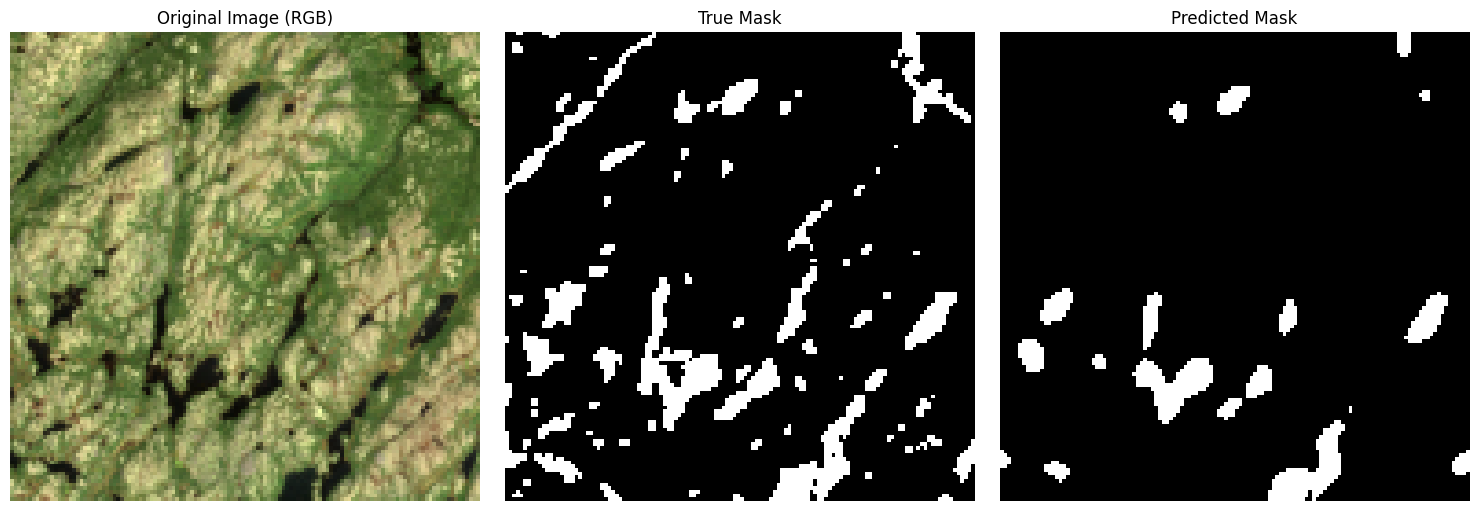

In [37]:
target_size=(128,128)
img_path = image_list[110]
label_path = label_list[110]
        
        # Load and preprocess the image and mask
img, true_mask = load_image(img_path, label_path, target_size)
        
        # Predict the mask
pred_mask = unet.predict(tf.expand_dims(img, axis=0))[0]
        
        # Create RGB image for visualization (assuming channels 3, 2, 1 correspond to RGB)
rgb_img = tf.stack([img[:,:,3], img[:,:,2], img[:,:,1]], axis=-1)
        
        # Convert to numpy and normalize for visualization
rgb_img_np = rgb_img.numpy()
rgb_img_np = (rgb_img_np - np.min(rgb_img_np)) / (np.max(rgb_img_np) - np.min(rgb_img_np))
        
        # Plot original RGB image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image (RGB)')
plt.imshow(rgb_img_np)
plt.axis('off')
        
        # Plot true mask
plt.subplot(1, 3, 2)
plt.title('True Mask')
plt.imshow(tf.squeeze(true_mask), cmap='gray')
plt.axis('off')
        
        # Plot predicted mask
plt.subplot(1, 3, 3)
plt.title('Predicted Mask')
plt.imshow(tf.squeeze(pred_mask) > 0.5, cmap='gray')
plt.axis('off')
        
plt.tight_layout()
plt.show()